# Dynamic range

In [96]:
import sys
sys.path.append('../')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

plt.rcParams["figure.figsize"] = [16,9]
sns.set(font_scale=3.0)

from network import run_network_recall, train_network, run_network_recall_limit
from connectivity import designed_matrix_sequences
from analysis import get_recall_duration_for_pattern, get_recall_duration_sequence

In [97]:
N = 10
self_excitation = 3.0
inhbition = 5.0
transition = 0.5
sequences = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
w = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, 
                              transition=transition, inhbition=inhbition)

G = 100.0
tau_m = 0.010
tau_z = 0.020
T = 2.0
I_cue = 0
T_cue = 0.100
dt = 0.0001
threshold = 0.5

dic = run_network_recall_limit(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue)

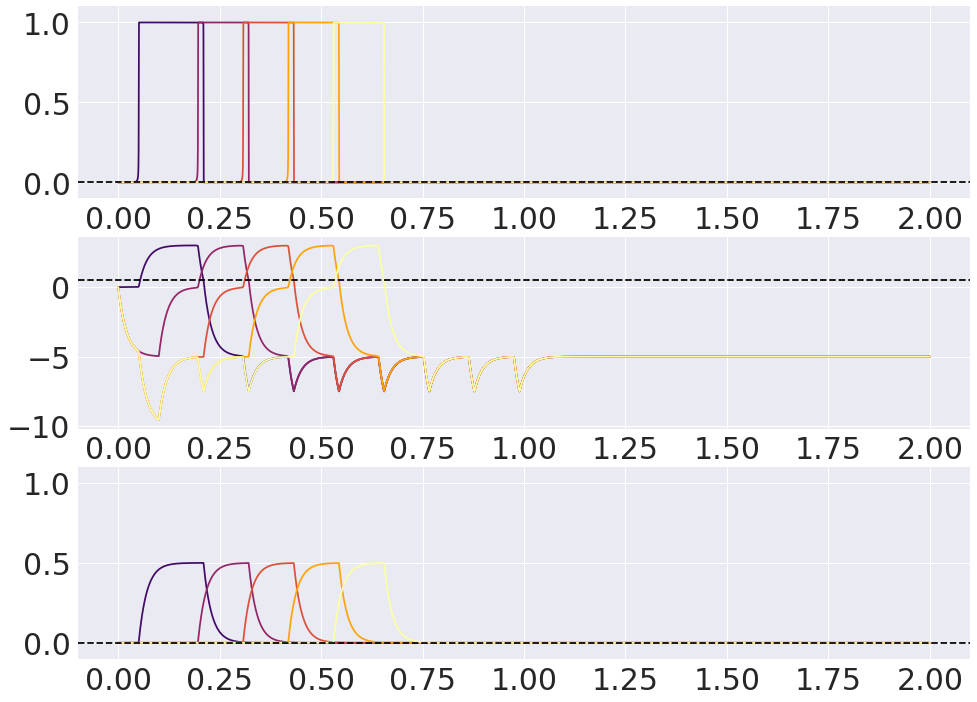

In [45]:
time = np.arange(0, T, dt)
x_history = dic['x']
z_history = dic['z']
current_history = dic['current']

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

patterns = [1, 2, 3, 4, 5]
cmap = matplotlib.cm.inferno
norm = matplotlib.colors.Normalize(0, len(patterns))

# patterns = sequence
for pattern in patterns:
    aux = current_history[:, pattern] - transition * z_history[:, pattern - 1]
    # aux = current_history[:, pattern]
    ax1.plot(time, x_history[:, pattern], color=cmap(norm(pattern)), label='x' + str(pattern))
    ax2.plot(time, aux, color=cmap(norm(pattern)), label='current' + str(pattern))
    ax3.plot(time, transition * z_history[:, pattern], color=cmap(norm(pattern)), label='z ' + str(pattern))
    
ax1.axhline(0, ls='--', color='black')

ax1.set_ylim([-0.1, 1.1])
ax3.set_ylim([-0.1, 1.1])

ax2.axhline(threshold, ls='--', color='black')


ax3.axhline(0, ls='--', color='black')

# ax1.legend();
# ax2.legend();
# ax3.legend();

### Comparison with non-limited recall

In [33]:
N = 10
sequences = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
self_excitation = 3.0
transition = 0.5
inhibition = 30.0

G = 120.0
tau_m = 0.010
tau_z = 0.020
T = 5.0
I_cue = 0
T_cue = 0.100
dt = 0.001

threshold = 0.5
tau_z = 0.050

pattern = 5
transition_vector = np.arange(0.40, 2.0, 0.05)
recall_times = []
recall_times_limit = []
for transition in transition_vector:
    w = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, transition=transition, 
                              inhbition=inhibition)

    dic = run_network_recall(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue)
    x_history = dic['x']
    duration = get_recall_duration_for_pattern(x_history, pattern, dt)
    recall_times.append(duration)
    dic = run_network_recall_limit(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue)
    x_history = dic['x']
    duration = get_recall_duration_for_pattern(x_history, pattern, dt)
    recall_times_limit.append(duration)

../network.py:5: RuntimeWarning: overflow encountered in exp
  return 1.0/(1 + np.exp(-G * x))


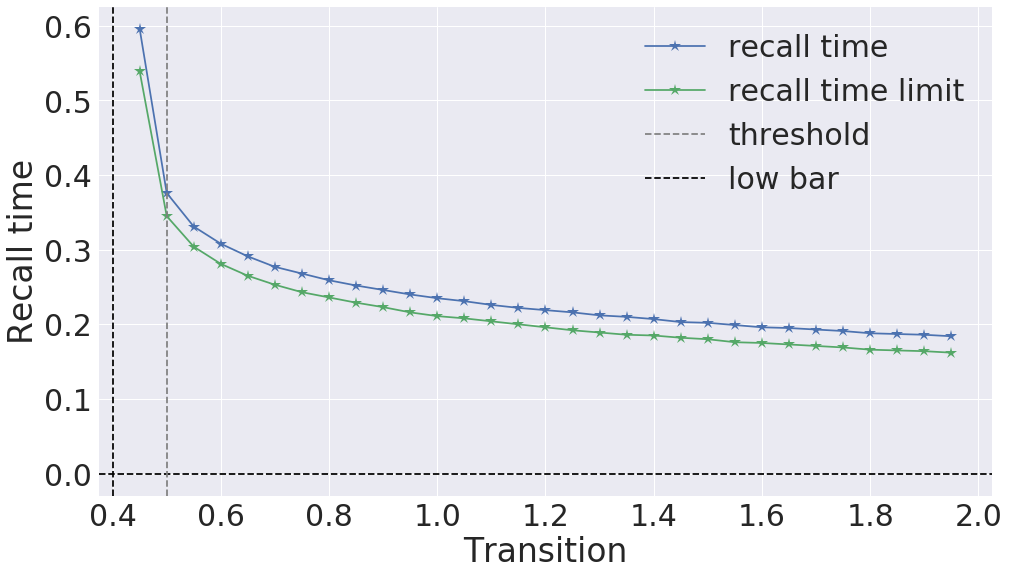

In [34]:
plt.plot(transition_vector, recall_times, '*-', markersize=13, label='recall time')
plt.plot(transition_vector, recall_times_limit, '*-', markersize=13, label='recall time limit')

plt.axhline(0, ls='--', color='black')
plt.axvline(threshold, ls='--', color='gray', label='threshold')
plt.axvline(transition_vector[0], ls='--', color='black', label='low bar')
plt.xlabel('Transition')
plt.ylabel('Recall time')
plt.legend();

## Looking inside the currents
Something is gronw, it seems tha for some reasons the threshold is actually **lower** than it should be. Threfore,, the transition term can become smaller than the actual trheshold but the transition still happens.

In [20]:
from network import phi

def run_network_recall_limit_inside(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue, sigma=0):

    x = np.zeros(N)
    current = np.zeros(N)
    current_A = np.zeros(N)
    current_T = np.zeros(N)
    current_I = np.zeros(N)
    current_rest = np.zeros(N)

    z = np.zeros(N)
    x[I_cue] = 1.0  # Initial condition
    z[I_cue] = 0.0

    x_history = []
    z_history = []
    current_history = []
    current_A_history = []
    current_T_history = []
    current_I_history = []
    current_rest_history = []

    steps = int(T / dt)
    steps_cue = int(T_cue / dt)
    for i in range(steps):
        x_history.append(np.copy(x))
        z_history.append(np.copy(z))
        current_history.append(np.copy(current))
        current_A_history.append(np.copy(current_A))
        current_T_history.append(np.copy(current_T))
        current_I_history.append(np.copy(current_I))
        current_rest_history.append(np.copy(current_rest))
    
        for k in range(N):
            current_A[k] = z[k] * w[k, k]
            index_transition = (k - 1) % N
            current_T[k] = z[index_transition] * w[k, index_transition]
            index_inhibition = (k + 1)  % N
            current_I[k] = z[index_inhibition] * w[k, index_inhibition]

        current_rest = current - current_A - current_I - current_T

        current = np.dot(w, z) + sigma * np.random.randn(N)
        x = phi(G, current - threshold)
        if i < steps_cue:
            x[I_cue] = 1
        z += (dt / tau_z) * (x - z)

    x_history = np.array(x_history)
    z_history = np.array(z_history)
    current_history = np.array(current_history)
    current_A_history = np.array(current_A_history)
    current_T_history = np.array(current_T_history)
    current_I_history = np.array(current_I_history)
    current_rest_history = np.array(current_rest_history)

    dic = {}
    dic['x'] = x_history
    dic['z'] = z_history
    dic['current'] = current_history
    dic['current_A'] = current_A_history
    dic['current_I'] = current_I_history
    dic['current_T'] = current_T_history
    dic['current_rest'] = current_rest_history

    return dic

In [20]:
N = 10
self_excitation = 3.0
inhbition = 5.0
transition = 0.47
sequences = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
w = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, 
                              transition=transition, inhbition=inhbition)

G = 200.0
tau_m = 0.010
tau_z = 0.020
T = 1.5
I_cue = 0
T_cue = 0.100
dt = 0.0001
threshold = 0.5

dic = run_network_recall_limit_inside(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue)

../network.py:5: RuntimeWarning: overflow encountered in exp
  return 1.0/(1 + np.exp(-G * x))


I want to see how much the self-excitation current plus the transition current account for the activation of a unit

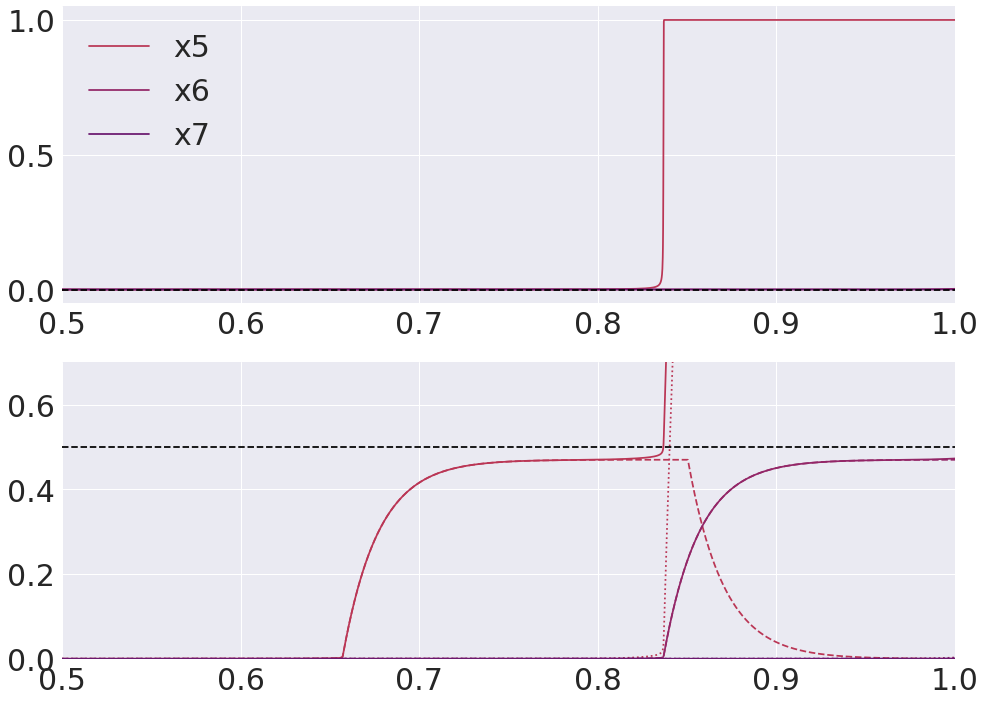

In [25]:
time = np.arange(0, T, dt)
x_history = dic['x']
z_history = dic['z']
current_history = dic['current']
current_A = dic['current_A']
current_T = dic['current_T']
current_I = dic['current_I']
current_rest = dic['current_rest']

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# ax3 = fig.add_subplot(413)
# ax4 = fig.add_subplot(414)

patterns = [5, 6, 7]
cmap = matplotlib.cm.inferno_r
norm = matplotlib.colors.Normalize(0, N)

# patterns = sequence
for pattern in patterns:
    aux = current_A[:, pattern] + current_T[:, pattern]
    ax1.plot(time, x_history[:, pattern] , color=cmap(norm(pattern)), label='x' + str(pattern))
    ax2.plot(time, aux, color=cmap(norm(pattern)), label='current' + str(pattern))
    ax2.plot(time, current_T[:, pattern], ls='--', color=cmap(norm(pattern)), label='x' + str(pattern))
    ax2.plot(time, current_A[:, pattern], ls=':', color=cmap(norm(pattern)), label='x' + str(pattern))

ax1.axhline(0, ls='--', color='black')

# ax1.set_ylim([-0.1, 1.1])
# ax3.set_ylim([-0.1, 1.1])

ax2.axhline(threshold, ls='--', color='black')

ax2.set_ylim([0.0, 0.7])
ax1.set_xlim([0.5, 1.0])
ax2.set_xlim([0.5, 1.0])

ax1.legend();

For some reason the self-exciting current starts a little bit before the transtion current overcomes the threshold. 
Why this could be? One possible explanation is that the it is just the nature of the fact that the sigmoid function is not completly a step function, in that case the finite size effects mean that x get's activated a little bit and therefore z_self punches the think up.

Let's try to make G as big as we can and see what happens with this effect

../network.py:5: RuntimeWarning: overflow encountered in exp
  return 1.0/(1 + np.exp(-G * x))


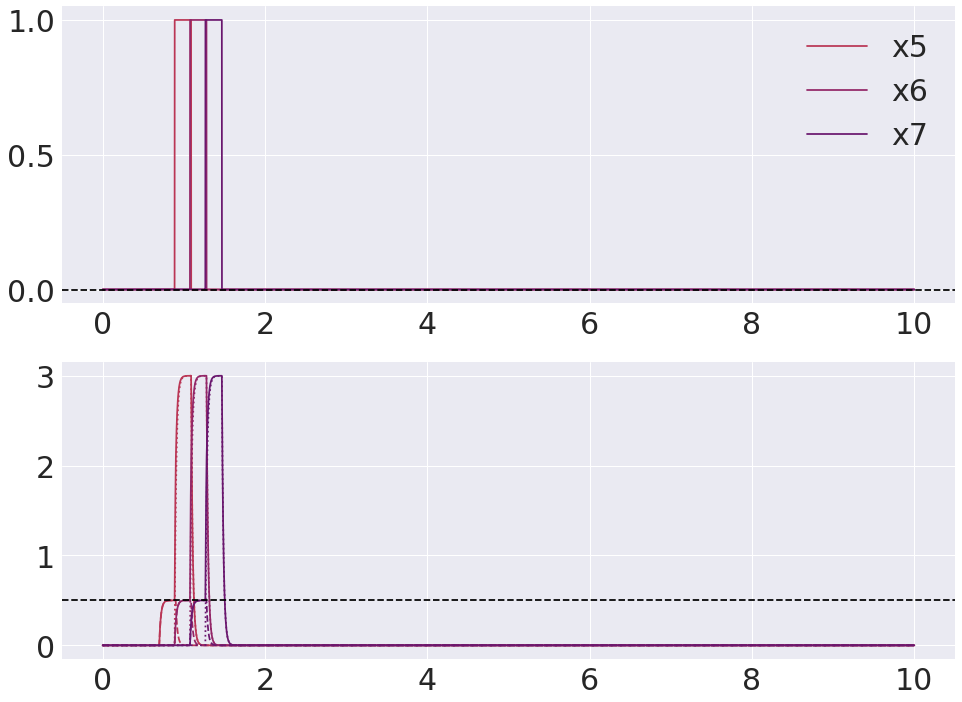

In [22]:
N = 10
self_excitation = 3.0
inhbition = 5.0
transition = 0.50
sequences = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
w = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, 
                              transition=transition, inhbition=inhbition)

G = 10000.0
tau_m = 0.010
tau_z = 0.020
T = 10.0
I_cue = 0
T_cue = 0.100
dt = 0.0001
threshold = 0.50

dic = run_network_recall_limit_inside(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue)


time = np.arange(0, T, dt)
x_history = dic['x']
z_history = dic['z']
current_history = dic['current']
current_A = dic['current_A']
current_T = dic['current_T']
current_I = dic['current_I']
current_rest = dic['current_rest']

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# ax3 = fig.add_subplot(413)
# ax4 = fig.add_subplot(414)

patterns = [5, 6, 7]
cmap = matplotlib.cm.inferno_r
norm = matplotlib.colors.Normalize(0, N)

# patterns = sequence
for pattern in patterns:
    aux = current_A[:, pattern] + current_T[:, pattern]
    ax1.plot(time, x_history[:, pattern] , color=cmap(norm(pattern)), label='x' + str(pattern))
    ax2.plot(time, aux, color=cmap(norm(pattern)), label='current' + str(pattern))
    ax2.plot(time, current_T[:, pattern], ls='--', color=cmap(norm(pattern)), label='x' + str(pattern))
    ax2.plot(time, current_A[:, pattern], ls=':', color=cmap(norm(pattern)), label='x' + str(pattern))

ax1.axhline(0, ls='--', color='black')

# ax1.set_ylim([-0.1, 1.1])
# ax3.set_ylim([-0.1, 1.1])

ax2.axhline(threshold, ls='--', color='black')

# ax2.set_ylim([0.0, 0.7])
# ax1.set_xlim([0.5, 1.0])
# ax2.set_xlim([0.5, 1.0])

ax1.legend();

This should not work if we run in with the limit version

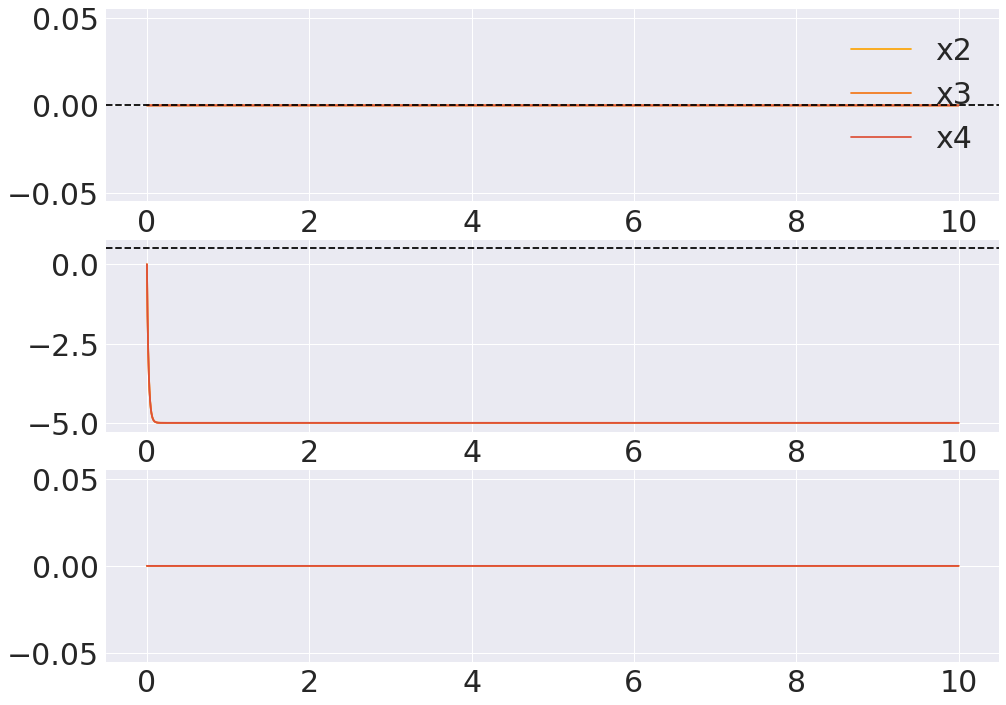

In [36]:
N = 10
self_excitation = 3.0
inhbition = 5.0
transition = 0.5
sequences = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
w = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, 
                              transition=transition, inhbition=inhbition)

G = 10000.0
tau_m = 0.010
tau_z = 0.020
T = 10.0
I_cue = 0
T_cue = 0.100
dt = 0.0001
threshold = 0.50

dic = run_network_recall_limit(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue)


time = np.arange(0, T, dt)
x_history = dic['x']
z_history = dic['z']
current_history = dic['current']

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
# ax4 = fig.add_subplot(414)

patterns = [2, 3, 4]
cmap = matplotlib.cm.inferno_r
norm = matplotlib.colors.Normalize(0, N)

# patterns = sequence
for pattern in patterns:
    ax1.plot(time, x_history[:, pattern] , color=cmap(norm(pattern)), label='x' + str(pattern))
    ax2.plot(time, current_history[:, pattern], color=cmap(norm(pattern)), label='current' + str(pattern))
    ax3.plot(time, z_history[:, pattern], color=cmap(norm(pattern)), label='current' + str(pattern))
    
ax1.axhline(0, ls='--', color='black')


ax2.axhline(threshold, ls='--', color='black')


ax1.legend();

It indeed does not work. Let's try small values close to the threhsold

0.50000000000001


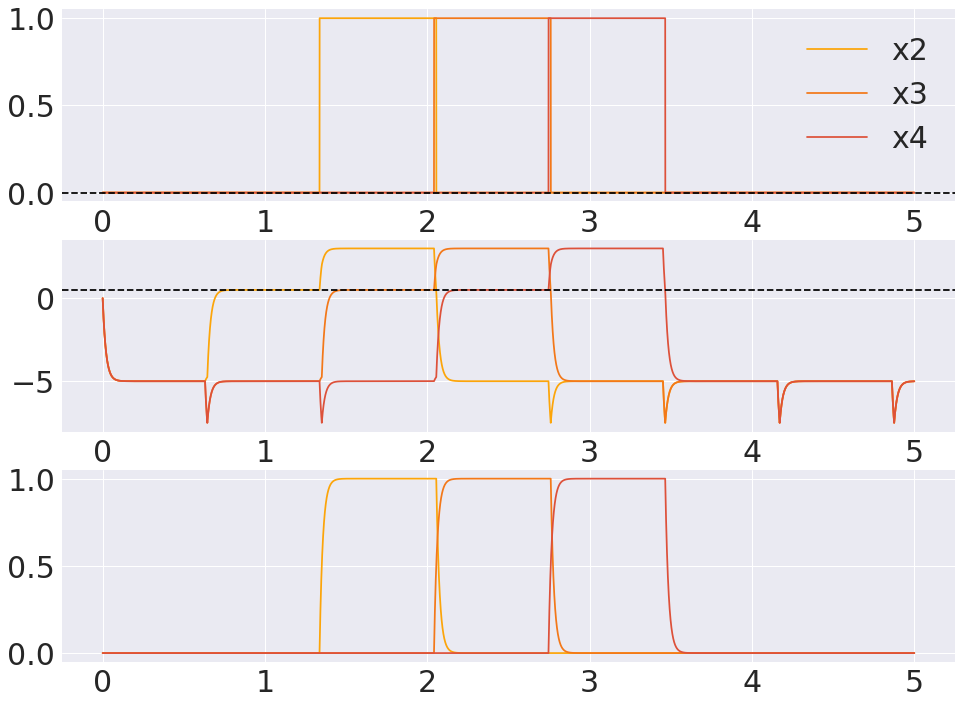

In [57]:
N = 10
self_excitation = 3.0
inhbition = 5.0
transition = 0.5 + 1e-14
print(transition)
sequences = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
w = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, 
                              transition=transition, inhbition=inhbition)

G = 10000.0
tau_m = 0.010
tau_z = 0.020
T = 5.0
I_cue = 0
T_cue = 0.100
dt = 0.0001
threshold = 0.50

dic = run_network_recall_limit(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue)


time = np.arange(0, T, dt)
x_history = dic['x']
z_history = dic['z']
current_history = dic['current']

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
# ax4 = fig.add_subplot(414)

patterns = [2, 3, 4]
cmap = matplotlib.cm.inferno_r
norm = matplotlib.colors.Normalize(0, N)

# patterns = sequence
for pattern in patterns:
    ax1.plot(time, x_history[:, pattern] , color=cmap(norm(pattern)), label='x' + str(pattern))
    ax2.plot(time, current_history[:, pattern], color=cmap(norm(pattern)), label='current' + str(pattern))
    ax3.plot(time, z_history[:, pattern], color=cmap(norm(pattern)), label='current' + str(pattern))
    
ax1.axhline(0, ls='--', color='black')


ax2.axhline(threshold, ls='--', color='black')


ax1.legend();

## Let's test the dynamic range with 

In [98]:
from network import run_network_recall_limit

In [106]:
N = 10
sequences = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
self_excitation = 1.0
transition = 0.5
inhibition = 1000.0

G = 1000000.0
tau_m = 0.010
T = 10.0
I_cue = 0
T_cue = 0.050
dt = 0.001

threshold = 0.5
tau_z = 0.050

pattern = 2
# transition_vector = np.arange(0.5, 0.7, 0.001)
transition_vector = np.logspace(-14, -0.3, 20) + 0.5
recall_times = []
for transition in transition_vector:
    w = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, transition=transition, 
                              inhbition=inhibition)

    dic = run_network_recall_limit(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue)
    x_history = dic['x']
    duration = get_recall_duration_for_pattern(x_history, pattern, dt)
    recall_times.append(duration)

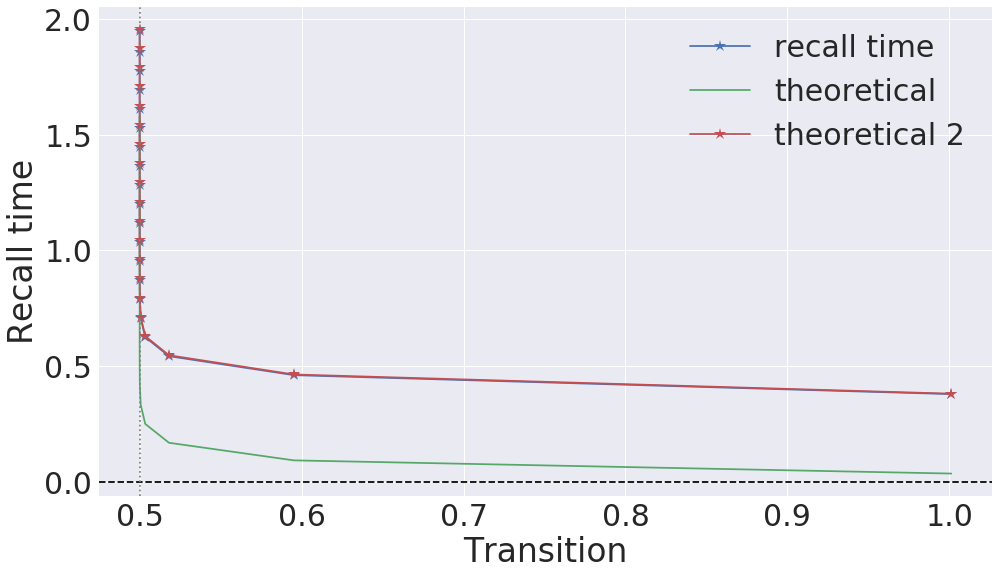

In [116]:
T_theo = -tau_z * np.log(1 - threshold / transition_vector)
T_theo2 = tau_z * np.log((transition_vector + inhibition) / (transition_vector - threshold))

plt.plot(transition_vector, recall_times, '*-', markersize=13, label='recall time')
plt.plot(transition_vector, T_theo, label='theoretical')
plt.plot(transition_vector, T_theo2, '*-', markersize=13, label='theoretical 2')
plt.axhline(0, ls='--', color='black')
plt.axvline(threshold, ls=':', color='grey')

plt.xlabel('Transition')
plt.ylabel('Recall time')
plt.legend();

There is a time that is not accounted here. The time it takes for the inhibitio coming from the next unit to take over the excitation produced by the self-activation current. What is the analytical formula for this

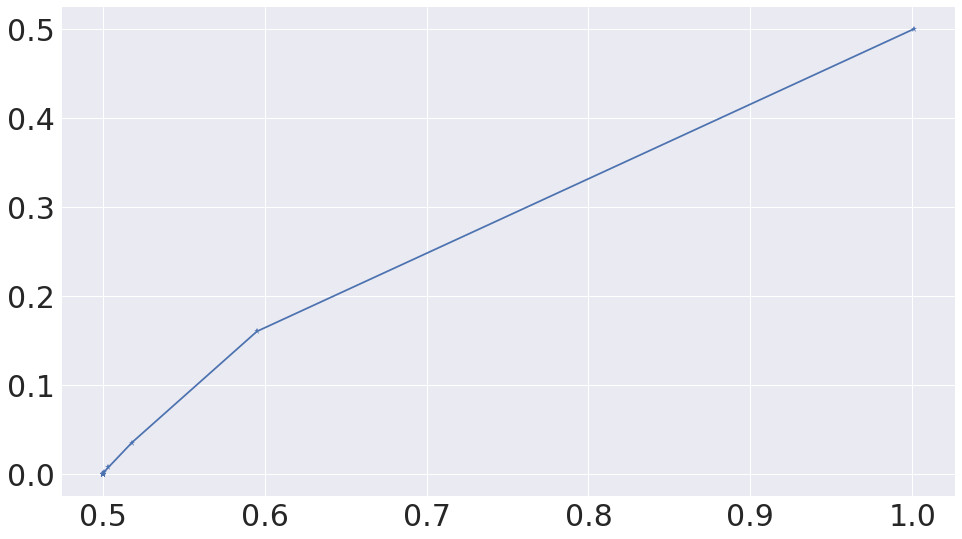

In [82]:
B = np.exp(-T1_theo / tau_z)
plt.plot(transition_vector, B, '*-');

/home/heberto/miniconda/envs/firing_rate_sequences/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


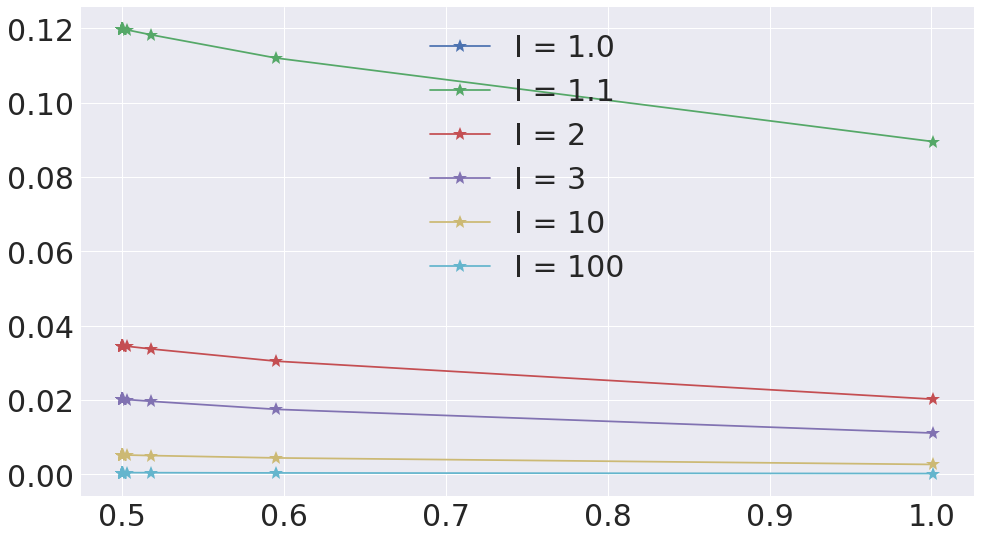

In [83]:
A = self_excitation

Is = [1.0, 1.1, 2, 3, 10, 100]

for I in Is:
    T2_theo = -tau_z * np.log((A - I) / (A * B - I))

    plt.plot(transition_vector, T2_theo, '*-', markersize=15, label='I = ' + str(I))
    
plt.legend();

Why as the transition becomes bigger T2 becomes smaller. The thing is that the bigger the transition the faster the filter corresponding to zi becomes fill. That means that by the time that the filter z_{i + 1} becomes activated the filter of z_{i} is not fully activated yet. That means that **the self-excitation current is smaller** and therefore the inhibitory current has less to overcome

In [84]:
A = self_excitation
I = inhibition 
T2_theo = -tau_z * np.log((A - I) / (A * B - I))

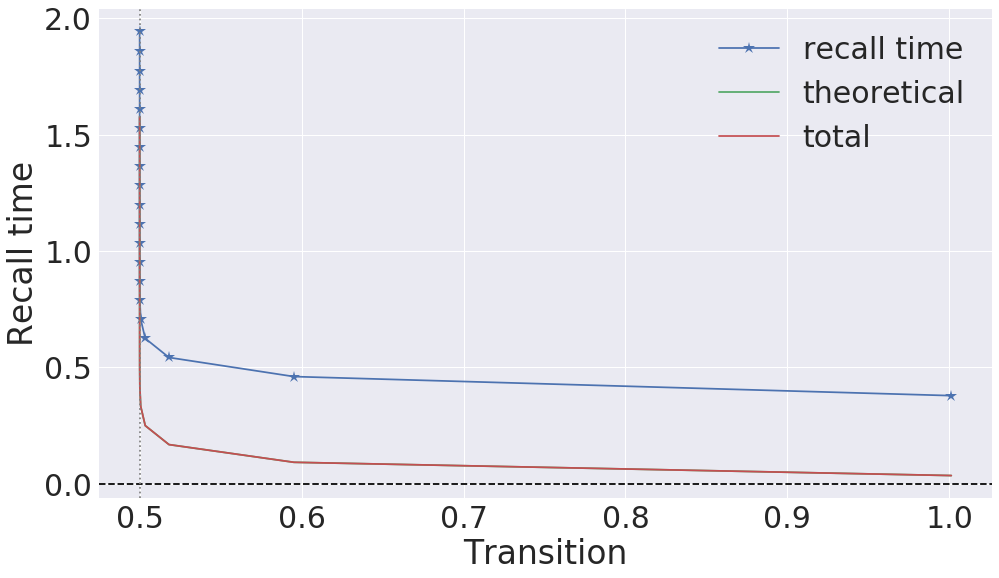

In [85]:
plt.plot(transition_vector, recall_times, '*-', markersize=13, label='recall time')
plt.plot(transition_vector, T1_theo, label='theoretical')
plt.plot(transition_vector, T1_theo + T2_theo, label='total')
plt.axhline(0, ls='--', color='black')
plt.axvline(threshold, ls=':', color='grey')

plt.xlabel('Transition')
plt.ylabel('Recall time')
plt.legend();

If the contribution for the inhibition beating the excitation does not work out in the expected way.  Maybe the fact that the transition is happening to fast means that the previous z transition are still contributing. So the previous one will be exciting and the past will be inhibitig. How this could play out? 

There are two options:
* The x_i last longers because the z_i is contributing excitation 
* The x_i last longers because the pasts z are inhibiting it. the x_i + 1. 

The second one I can test by creating a different matrix with very localized feed-back interactions instead of generalized ones.

In [92]:
def designed_matrix_sequences_local(N, sequences, self_excitation=1, transition=1, inhbition=1):
    w = np.zeros((N, N))

    # Self-excitation
    for sequence in sequences:
        for element in sequence:
            w[element, element] = self_excitation

    # sequence
    for sequence in sequences:
        for index in range(len(sequence) - 1):
            w[sequence[index + 1], sequence[index]] = transition
            w[sequence[index], sequence[index + 1]] = -inhbition
    
    return w 

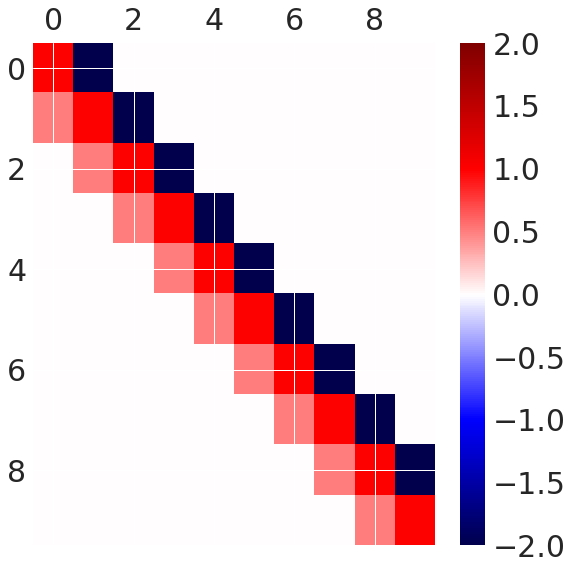

In [93]:
N = 10
sequences = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
self_excitation = 1.0
transition = 0.5
inhibition = 2.0

w = designed_matrix_sequences_local(N, sequences, self_excitation=self_excitation, transition=transition, 
                              inhbition=inhibition)


symmetric = np.max((np.max(w), np.abs(np.min(w))))
plt.matshow(w, aspect='auto', vmin=-symmetric, vmax=symmetric, cmap='seismic')
plt.colorbar();

In [94]:
N = 10
sequences = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
self_excitation = 1.0
transition = 0.5
inhibition = 1000.0

G = 1000000.0
tau_m = 0.010
T = 10.0
I_cue = 0
T_cue = 0.050
dt = 0.001

threshold = 0.5
tau_z = 0.050

pattern = 2
transition_vector = np.arange(0.5, 0.7, 0.001)
transition_vector = np.logspace(-14, -0.3, 20) + 0.5
recall_times = []
for transition in transition_vector:
    w = designed_matrix_sequences_local(N, sequences, self_excitation=self_excitation, transition=transition, 
                                        inhbition=inhibition)

    dic = run_network_recall_limit(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue)
    x_history = dic['x']
    duration = get_recall_duration_for_pattern(x_history, pattern, dt)
    recall_times.append(duration)

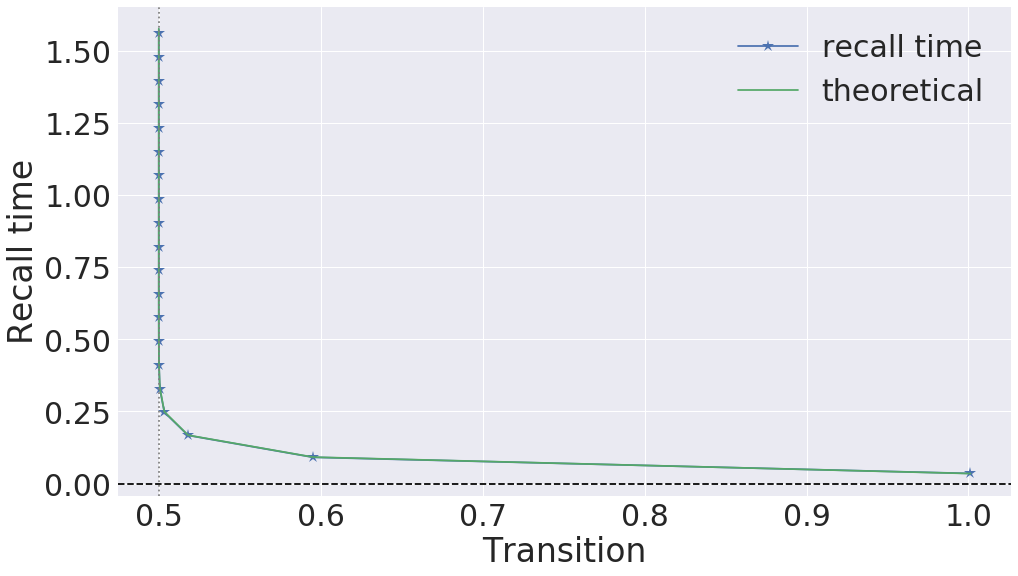

In [95]:
T1_theo = -tau_z * np.log(1 - threshold / transition_vector)

plt.plot(transition_vector, recall_times, '*-', markersize=13, label='recall time')
plt.plot(transition_vector, T1_theo, label='theoretical')
plt.axhline(0, ls='--', color='black')
plt.axvline(threshold, ls=':', color='grey')

plt.xlabel('Transition')
plt.ylabel('Recall time')
plt.legend();

This concludes that effectively is the inhibition of the one element before the last that impeedes the transtion to happen at a very fast rate. 